In [1]:
import transformer_utils_subset as tus 
# this is the subset of transformer_utils module from the Nano-Transformer directory, including only the 
# functions needed for the diffusion transformer

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch.nn as nn
from tqdm.notebook import trange, tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Embedders for timesteps and context

In [4]:
class TimestepEmbedder(nn.Module):
    """Projects each time step to an embedded vector of length d using a simple MLP
    [num_timesteps] --> [num_timesteps, d] """
    
    def __init__(self, d):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, d),
            tus.GELU(),
            nn.Linear(d, d)
        )

    def forward(self, t): # t: [num_timesteps]
        t = t.unsqueeze(-1)  #[num_timesteps,1]
        embeddings = self.mlp(t) #[num_timesteps, d]
        return embeddings  

In [5]:
class LabelEmbedder(nn.Module): 
    """
    Gets a batch of labels of size B and return a labels of size B with some labels "dropped" 
    according to drop-out probability (dpo). Dropped labels are replaced with self.num_classes.
    """
    
    def __init__(self, num_classes, d, dpo=0.1):
        super().__init__()
        self.embedding_table = nn.Embedding(num_classes + 1, d)
        # assume classes labeled as 0, 1,..
        # num_classes + 1 handles the case where a label is dropped 
        # we use the number of classes as the placeholder for dropped labels, 
        # e.g., use 10 when the class labels are nominally from 0 to 9
        self.num_classes = num_classes
        self.dpo = dpo #Prob. of dropping a label 

    def token_drop(self, labels):
        
        # Return a boolean vector according to dpo value, e.g., [True, True, ..]
        drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dpo #[B]
        
        # wherever drop_ids is True, insert #num_classes (which is the fake label)
        labels = torch.where(drop_ids, self.num_classes, labels) #[B]        
        return labels

    def forward(self, labels, train):
        labels = labels.to(device)
        
        #Modulate labels based on drop_prob
        if train and self.dpo > 0:
            labels = self.token_drop(labels) # [B]
            
        # Pass the labels through the embedding table to get their vector representations
        embeddings = self.embedding_table(labels) #[B,d]
        
        return embeddings

### DiT model with adaptive layer norm

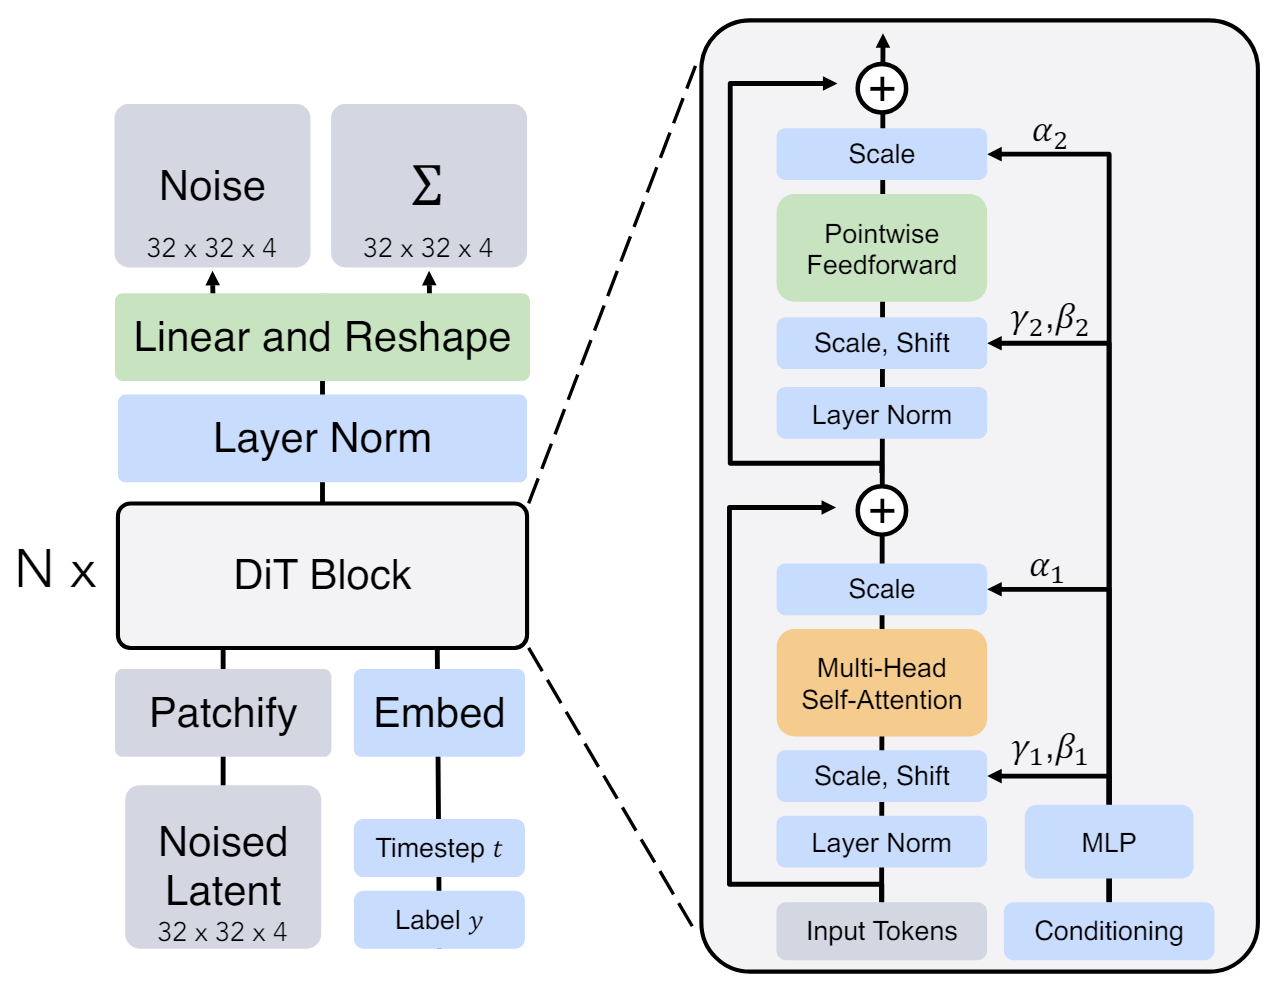

In [6]:
# Using the code cell rather than a markdown cell to avoid rendering issues in GitHub
Image(filename="images/DiT_architecture_with_adaptive_layer_norm.png", width=500)

In [7]:
def modulate(x, shift, scale):
    """Helper function to replace standard layernorm layers in transformer blocks with adaptive layer
    norm (adaLN). Modulates layernorm outputs (x) through scale and shift parameters (which, in DiT, are 
    function of (sum of) time-and context-embedding vectors."""
    #x: [B,num_patches,d]
    #scale, shift: [B,d] --> unsqueeze(1) --> [B,1,d]
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1) #[B,num_patches,d]

In [8]:
class TransformerBlockEncoder_DiT(nn.Module): 
    """Follows TransformerBlockEncoder from transformer_utils (under Nano-transformer repository), except
    the layernorm layers modulated with time and label embeddings."""
    
    def __init__(self, d, nh, dpo): 
        super().__init__()
        
        #Original encoder layers
        self.mha = tus.MHA(d, nh, dpo) #no masking in attention
        self.ffn = tus.FFN(d)
        self.norm_premha = tus.LayerNorm(d)
        self.norm_preffn = tus.LayerNorm(d)
        self.drop_post = nn.Dropout(dpo)
        
        #DiT-specific layers        
        layer_names = ['gamma_1', 'beta_1', 'gamma_2', 'beta_2', 'alpha_1', 'alpha_2']
        self.layers = nn.ModuleDict({name: nn.Linear(d, d) for name in layer_names})
        
    def forward(self, x, c):   
        #x: [B,num_patches,d]
        #c: time and label embeddings [B,d], c --> t + c at training 
        
        # scale/shift factors modulated by c        
        scale_mha = self.layers['gamma_1'](c) #[B,d]
        shift_mha = self.layers['beta_1'](c) #[B,d]
        gate_mha =  self.layers['alpha_1'](c).unsqueeze(1) #MHA scaler post attention [B,1,d]

        scale_ffn = self.layers['gamma_2'](c) #[B,d]
        shift_ffn = self.layers['beta_2'](c) #[B,d]
        gate_ffn = self.layers['alpha_2'](c).unsqueeze(1) #FFN scaler post attention [B,1,d]
        
        x1 = x 
        x = self.norm_premha(x) #[B,num_patches,d]
        x = modulate(x, shift_mha, scale_mha) #[B,num_patches,d], DiT-specific
        x = self.mha(x) #[B,num_patches,d]
        x = x*gate_mha #[B,num_patches,d], DiT-specific
        x = self.drop_post(x)
        x = x + x1 #[B,num_patches,d]
        
        x1 = x 
        x = self.norm_preffn(x)
        x = modulate(x, shift_ffn, scale_ffn) #[B,num_patches,d], DiT-specific
        x = self.ffn(x) #[B,num_patches,d]
        x = x * gate_ffn #[B,num_patches,d], DiT-specific
        x = self.drop_post(x) 
        x = x + x1 #[B,num_patches,d]

        return x

In [9]:
class FinalLayer(nn.Module):
    """In addition to projecting the output to [B,num_patches,P*P*Cin] space,
    includes one last modulation of layernorm by the context and timesteps"""
    
    def __init__(self, d, P, Cin):
        super().__init__()
        self.gamma = nn.Linear(d, d)
        self.beta = nn.Linear(d, d)  
        self.layernorm_final = nn.LayerNorm(d)
        self.linear = nn.Linear(d, P*P*Cin) # Cout = Cin

    def forward(self, x, c): #c --> t + c at training
        #x: [B,num_patches,d]
        #c: [B,d]
        scale = self.gamma(c) #[B,d]
        shift = self.beta(c) #[B,d]
        x = self.layernorm_final(x) #[B,num_patches,d]
        x = modulate(x, shift, scale) #[B,num_patches,d]
        x = self.linear(x)  #[B,num_patches,P*P*Cin]
        return x

In [10]:
class DiTc(nn.Module): 
    """Full diffusion transformer with context"""
    
    def __init__(self, H, d, P, L, nh, Cin, dpo, dpo_label, num_classes=10):
        super().__init__()
        
        """
        H: image height = width
        d: time, label, patch, position embedding size
        P: patch height = width
        L: number of encoder blocks
        nh: number of attention heads
        Cin: num input channels
        """
        
        #the simplest possible embedding layers:
        self.timestep_embedder = TimestepEmbedder(d)
        self.context_embedder = LabelEmbedder(num_classes, d, dpo_label) 
        
        self.patch_embedder = tus.Patchify(H, P, Cin, d) # as used in ViT
        self.num_patches = self.patch_embedder.num_patches
        self.num_patches_per_side = int(self.num_patches ** 0.5)
        
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, d)) 
        
        #encoder blocks with adaLN
        self.transformer = nn.ModuleList()
        for i in range(L):
            self.transformer.append(TransformerBlockEncoder_DiT(d, nh, dpo))

        #projection layer
        self.final = FinalLayer(d, P, Cin) 
        
        #image resolution recovery (unpatchify)
        self.upscale_image = nn.PixelShuffle(P) 
      
    
    def forward(self, x, t, c, train=True):   
        """
        x: [B, Cin, W, H], image tensor
        t: [B,] timesteps
        c: [B,] class labels
        """
        
        # embed t and c
        t = t.to(device) 
        t = self.timestep_embedder(t) # [B,d]

        c = c.to(device)
        c = self.context_embedder(c, train) # [B,d]
        
        tplusc = t+c #[B,d]
        
        #embed image patches and positions
        x = self.patch_embedder(x) #[B, num_patches, d] 

        x += self.pos_embedding #[B,num_patches,d] + [1, num_patches,d] = [B,num_patches,d] 
        
        #transformer encoder with adaLN
        for layer in self.transformer:
            x = layer(x, tplusc) #[B, num_patches, d] (transformer output)

        #DiT-specific final layer
        x = self.final(x, tplusc) #[B, num_patches, P*P*Cin], last term is the num_pixels per patch
        
        #unpatchify
        x = x.permute([0, 2, 1]) #[B, P*P*Cin, num_patches]
        x = x.view(x.shape[0], x.shape[1], self.num_patches_per_side, self.num_patches_per_side) #[B, P*P*Cin, H/P, W/P] 
        x = self.upscale_image(x) #[B, Cin, H, W], recovering the original image tensor size

        return x

### Variance schedule

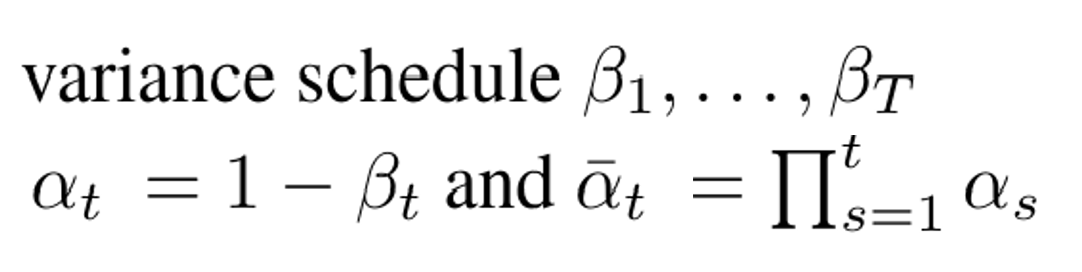

In [11]:
Image(filename="images/variance_schedule.png", width=300)

In [12]:
# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

In [13]:
#variance schedule, linearly dividing the space between beta1 and beta2
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1 #variance schedule
a_t = 1 - b_t #alpha_t = 1-beta_t

#below formulation efficiently computes the cumulative product of a tensor's elements along dim  
ab_t = torch.cumsum(a_t.log(), dim=0).exp() 
ab_t[0] = 1

### Training

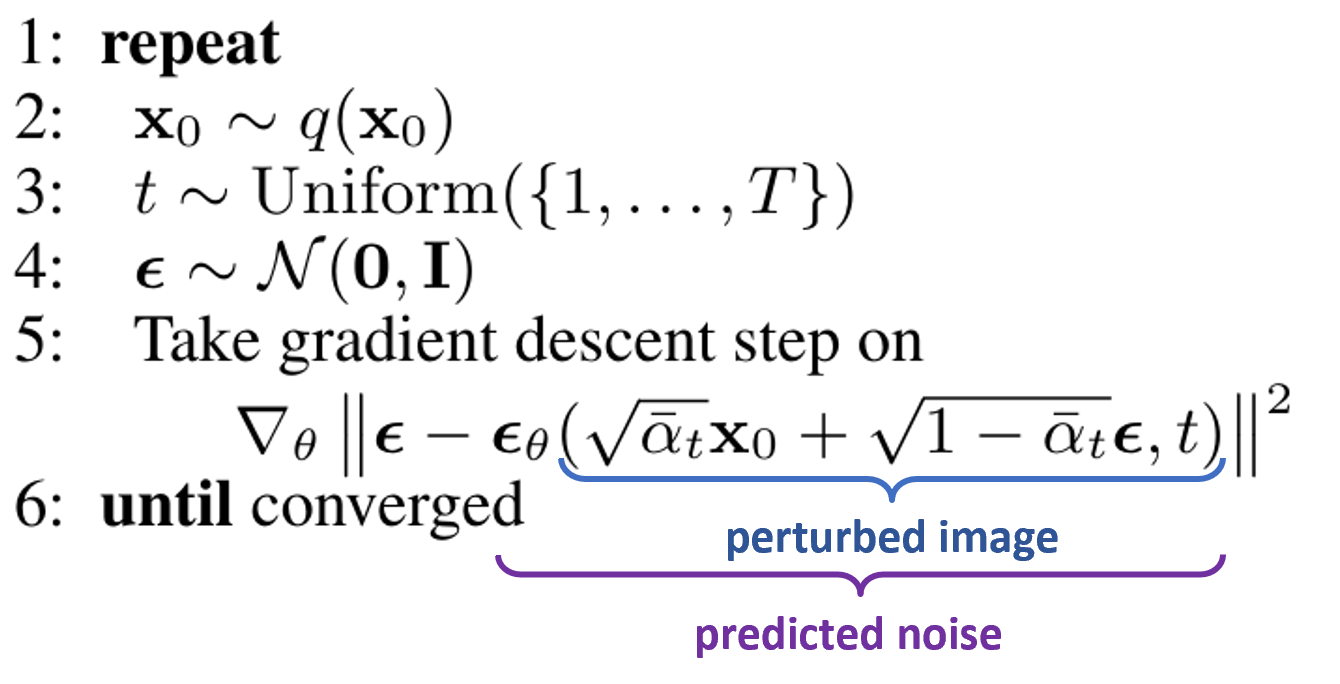

In [14]:
Image(filename="images/training.png", width=400)

In [15]:
def plot_loss(train_losses):
    """Plots the loss vs. epochs."""
    num_epochs = len(train_losses) 
    epochs = torch.arange(1, num_epochs+1, 1)
    plt.grid()
    train_losses_cpu = [t.cpu().item() for t in train_losses]
    plt.plot(epochs, train_losses_cpu)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [16]:
def perturb_input(x0, t, noise):
    """Adds noise to an image according to variance schedule."""
    # ab_t dimension changed to match x's
    return ab_t[t, None, None, None].sqrt() * x0 + (1 - ab_t[t, None, None, None]).sqrt() * noise

In [17]:
# Training parameters

num_batches = 64
num_epochs = 20

#Assume MNIST data available in the root
train_data = MNIST(root="training data", train=True, download=True, transform=ToTensor())
dataloader = DataLoader(train_data, batch_size=num_batches, shuffle=True, drop_last=True)

model = DiTc(H=28, d=256, P=4, L=8, nh=8, Cin=1, dpo=0.1, dpo_label=0.1, num_classes=10).to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

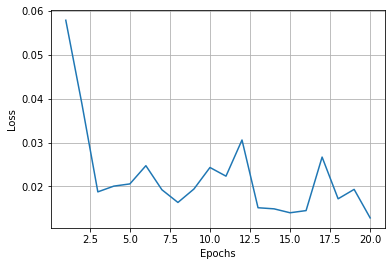

In [18]:
# Training loop

lowest_loss = float('inf')
train_losses, val_losses = [], []

for epoch in trange(num_epochs): 
    
    for (x, y) in tqdm(dataloader, leave=False):  # x: images  y: labels

        x = x.to(device) #[B,Cin,W,H]
        y = y.to(device)

        optimizer.zero_grad() 

        noise = torch.randn_like(x) #[B,Cin,W,H]
        
        #sample a timestep between 1 and timesteps for each batch
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) #[B]
        
        #corrupt the image for the specific t and corresponding alpha_bar
        x_pert = perturb_input(x, t, noise) #[B,Cin,W,H]

        # fwd pass to predict noise, function of t and c
        pred_noise = model(x_pert, t/timesteps, c=y, train=True) #[B,Cin,W,H]
             
        # loss relates to the difference between the original and predicted noise
        loss = criterion(pred_noise, noise).to(device)
        
        # the lowest loss determines the model params
        if loss < lowest_loss:
            lowest_loss = loss
            trained_params = model.state_dict()
        
        loss.backward()
        
        optimizer.step()
    
    train_losses.append(loss)

plot_loss(train_losses)
#torch.save(trained_params, f"trained_model.pth")

### Sampling

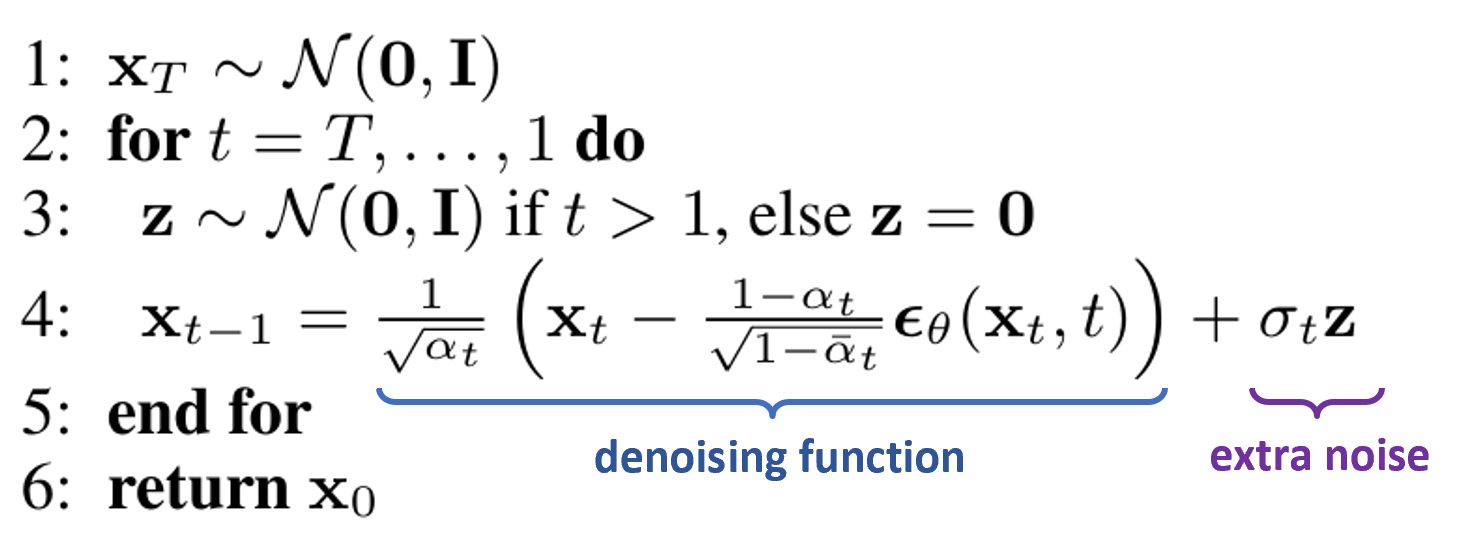

In [19]:
Image(filename="images/sample.png", width=400)

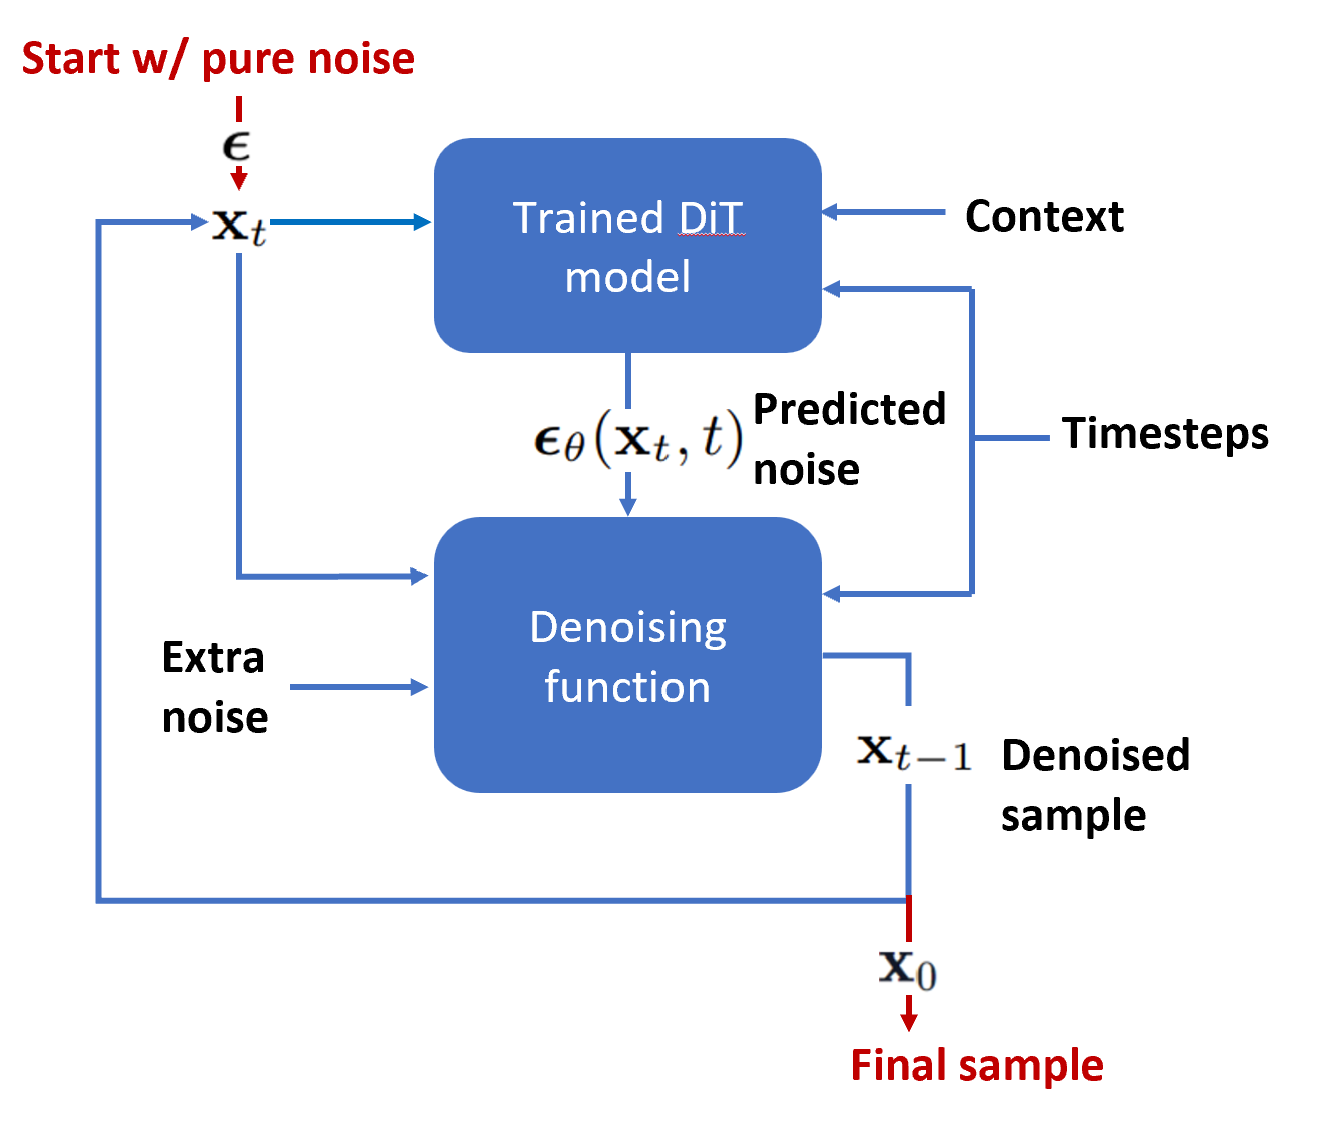

In [20]:
Image(filename="images/inference.png", width=500)

In [21]:
# Load the model weights (to skip the training, which would take ~20 mins using a GeForce RTX 3080)
# model.load_state_dict(torch.load('trained_model.pth')) 
model.eval();

In [22]:
def denoise(x, t, pred_noise, extra_noise, s4):
    """Removes the predicted noise from the image and adds extra_noise for more variety.
    Varying the new argument s4 from 1 to 0 adjusts the strength of extra noise. It thereby 
    reduces the variety of generated samples while improving their quality. Its nominal 
    (theoretical) value of 1 leads to maximum variety, while s4 = 0 essentially leads to 
    deterministic generation with zero variety. Optimal value lies between 1 and 0 (combining 
    decent variety and quality)"""
    s1 = 1 / a_t.sqrt()[t]
    s2 = (1 - a_t[t]) / (1 - ab_t[t]).sqrt()
    s3 = b_t[t].sqrt() 
    return s1*(x-s2*pred_noise)+s3*s4*extra_noise

In [23]:
@torch.no_grad()
def generate_with_context(c, s4, Cin=1, H=28, W=28): 
    """Generates images according to context, c. Starts with pure noise, predicts the 
    noise at each time step by fwd pass, and gradually subtracts it from the image."""
    
    # each sample consists of just noise to begin with: x_T ~ N(0, 1)
    x = torch.randn(c.shape[0], Cin, W, H).to(device)  

    for t in range(timesteps, 0, -1):
        print(f'sampling timestep: {t:4d}', end='\r')

        extra_noise = torch.randn_like(x).to(device) if t > 1 else 0 
        t_norm = torch.tensor([t / timesteps]).to(device)

        #predict noise
        pred_noise = model(x, t_norm, c, train=False).to(device)
        
        #subtract the noise from the noisy sample
        x = denoise(x, t, pred_noise, extra_noise, s4)

    return x

In [24]:
def show_genims(s4):
    """Shows the MNIST digits generated according to s4 parameter in a 5x10 matrix."""
    nrow, ncol = 5, 10
    c = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device) # Context
    c5x = torch.tile(c, (nrow,))
    gen_ims = generate_with_context(c5x,s4)
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(gen_ims):
        plt.subplot(nrow, ncol, i + 1)
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

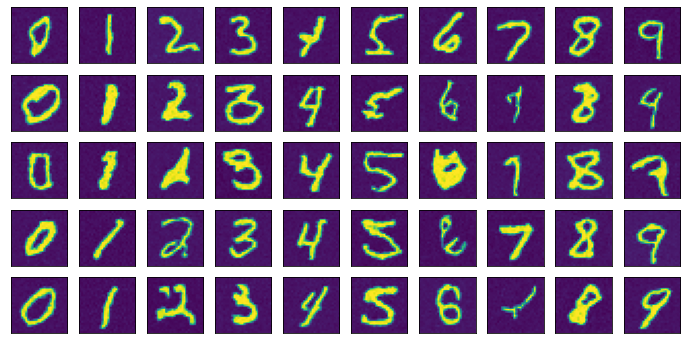

In [38]:
show_genims(s4 = 1) # generation with max extra noise

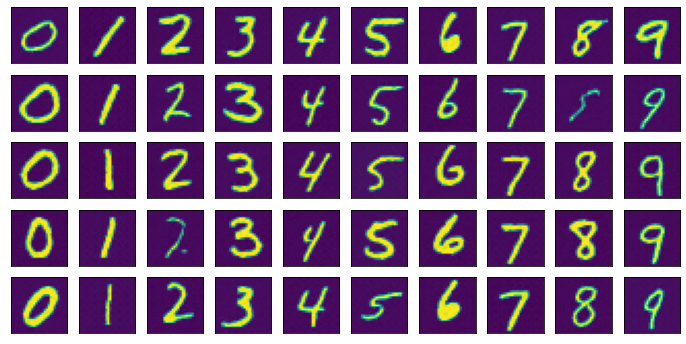

In [37]:
show_genims(s4 = 0.6) # generation with ~optimal noise

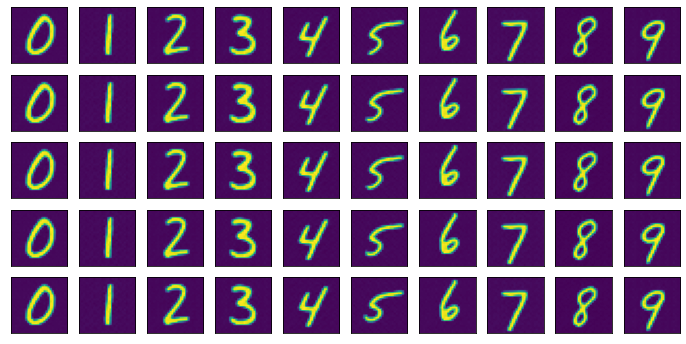

In [27]:
show_genims(s4 = 0) #generation with no extra noise (deterministic case)